## Importing the Required Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as  np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import CSVLogger

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Setting Constants

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 40
SEED = 42
VAL_SPLIT = 0.2
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

## Data Loading & Splitting dataset into train and validation sets

In [4]:
train_ds = image_dataset_from_directory(
    "data",
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    validation_split = VAL_SPLIT,
    subset = "training",
    shuffle = True,
    seed = SEED,
)
val_ds = image_dataset_from_directory(
    "data",
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    validation_split = VAL_SPLIT,
    subset = "validation",
    shuffle = True,
    seed = SEED,
)

Found 16011 files belonging to 10 classes.
Using 12809 files for training.
Found 16011 files belonging to 10 classes.
Using 3202 files for validation.


### Further split into validation set and test set

In [5]:
val_split = 0.5 
val_ds_size = len(val_ds)
val_size = int(val_split * val_ds_size)

test_ds = val_ds.take(val_size)
val_ds = val_ds.skip(val_size)

In [6]:
print(f"Number of training batches: {len(train_ds)}")
print(f"Number of validatiing batches: {len(val_ds)}")
print(f"Number of testing batches: {len(test_ds)}")

Number of training batches: 401
Number of validatiing batches: 51
Number of testing batches: 50


### Class Names

In [7]:
class_names = train_ds.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

## Visualize some images from the dataset

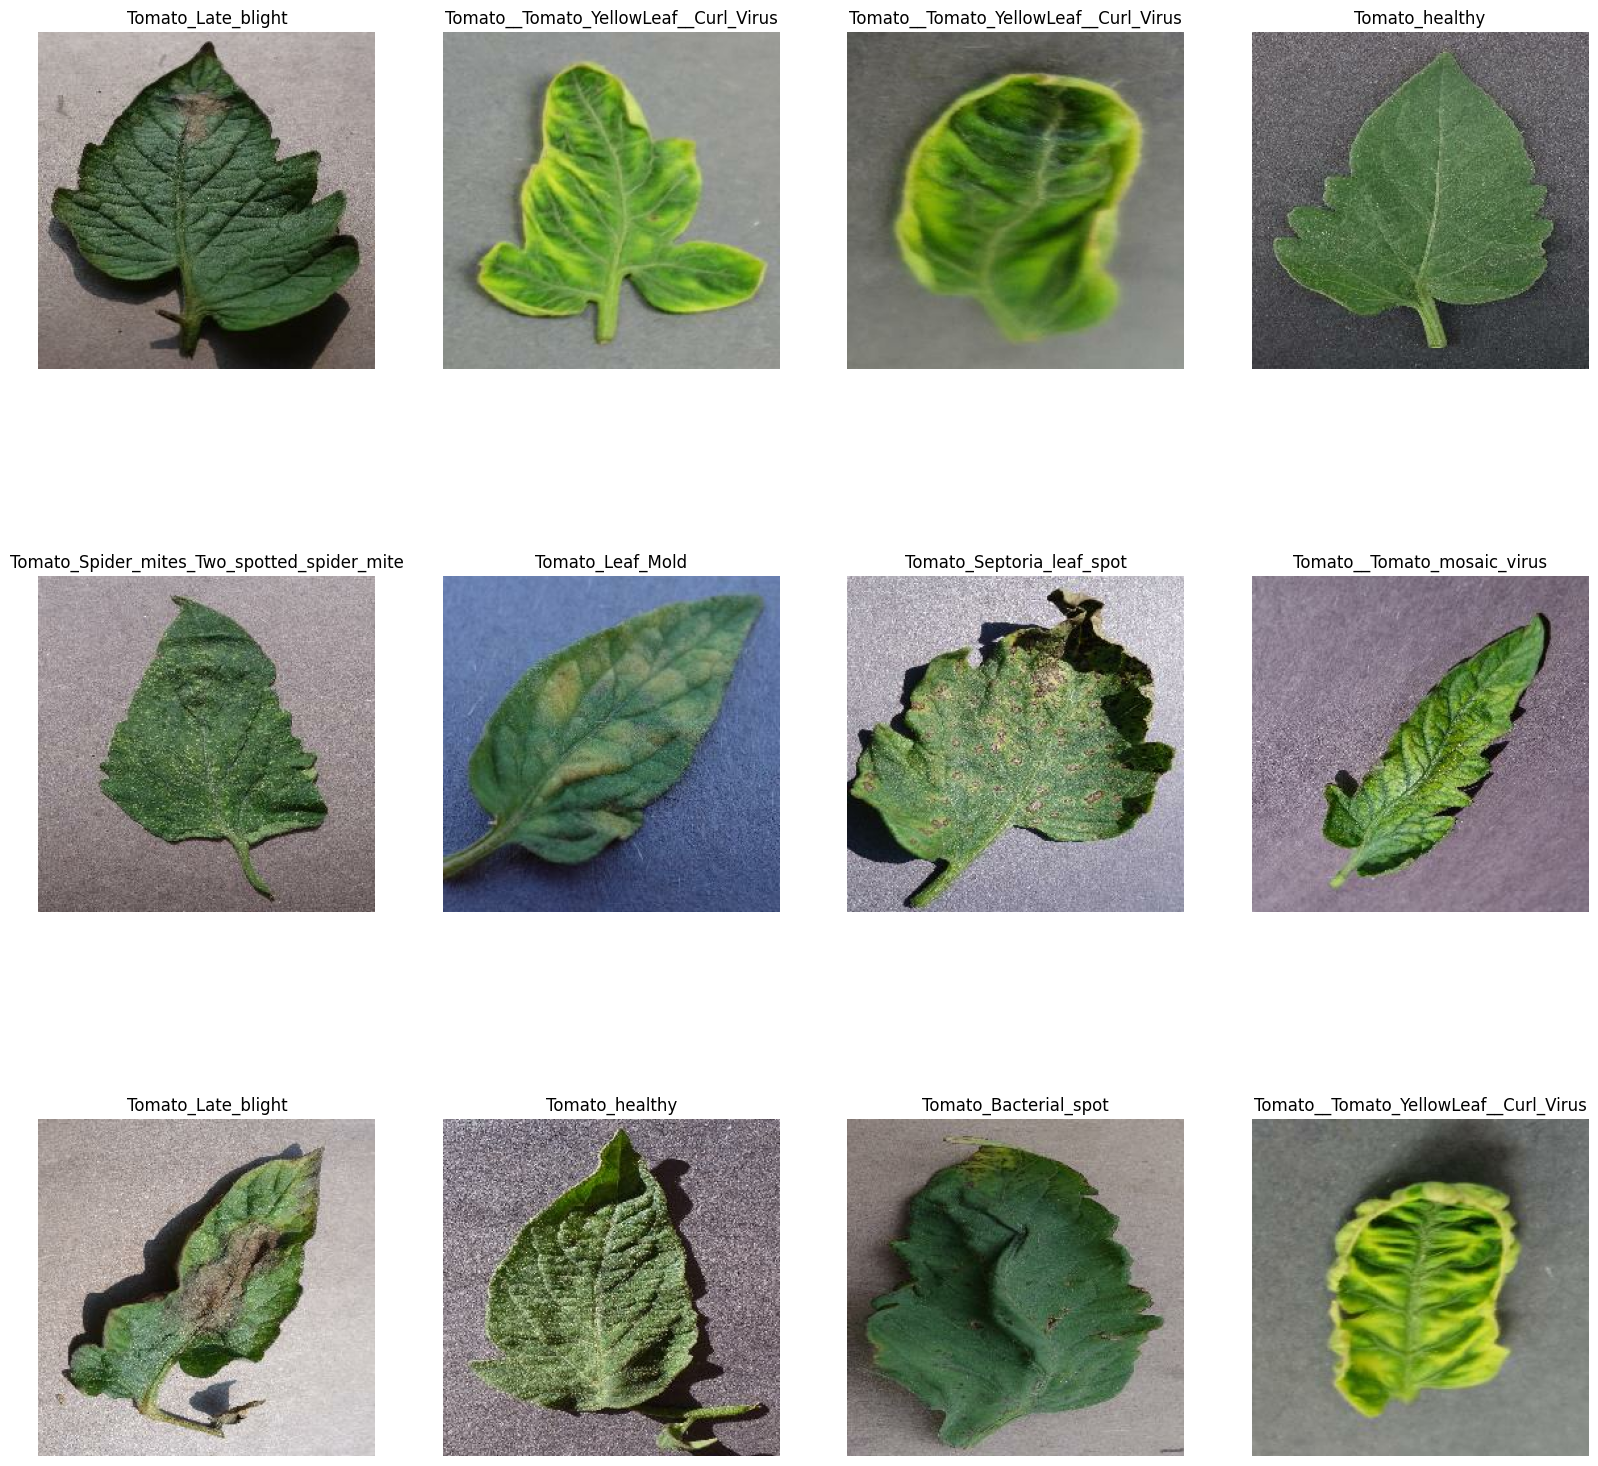

In [8]:
plt.figure(figsize = (20, 20))
for image_batch, label_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

## Optimizing the performance of input pipelines

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

## Resizing and Normalizing the images

In [10]:
resize_and_rescale = tf.keras.Sequential([
    preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    preprocessing.Rescaling(1.0 / 255)
])

## Data Augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomContrast(0.3)
])

## Model Architecture

In [12]:
n_classes = len(class_names)
n_classes

10

In [13]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=INPUT_SHAPE)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

## Compiling the model

- `adam` Optimizer with default learning rate (0.001)
- `SparseCategoricalCrossentropy` for losses
- `accuracy` as a metric

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

We monitors the validation loss during model training and stops training if the validation loss does not improve for 10 consecutive epochs.

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

### Training the model

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/40
401/401 [==============================] - 142s 302ms/step - loss: 1.8804 - accuracy: 0.3167 - val_loss: 1.5299 - val_accuracy: 0.4519
Epoch 2/40
401/401 [==============================] - 108s 270ms/step - loss: 1.4844 - accuracy: 0.4734 - val_loss: 1.1880 - val_accuracy: 0.5830
Epoch 3/40
401/401 [==============================] - 109s 272ms/step - loss: 1.1660 - accuracy: 0.5975 - val_loss: 1.1891 - val_accuracy: 0.6149
Epoch 4/40
401/401 [==============================] - 105s 263ms/step - loss: 0.9609 - accuracy: 0.6663 - val_loss: 0.7655 - val_accuracy: 0.7097
Epoch 5/40
401/401 [==============================] - 104s 259ms/step - loss: 0.7822 - accuracy: 0.7289 - val_loss: 0.5963 - val_accuracy: 0.7890
Epoch 6/40
401/401 [==============================] - 102s 254ms/step - loss: 0.6925 - accuracy: 0.7553 - val_loss: 0.5471 - val_accuracy: 0.8221
Epoch 7/40
401/401 [==============================] - 103s 258ms/step - loss: 0.6241 - accuracy: 0.7844 - val_loss: 0.4629 -

Epoch 16/40
401/401 [==============================] - 106s 264ms/step - loss: 0.3407 - accuracy: 0.8873 - val_loss: 0.4379 - val_accuracy: 0.8689
Epoch 17/40
401/401 [==============================] - 106s 264ms/step - loss: 0.3198 - accuracy: 0.8981 - val_loss: 0.4270 - val_accuracy: 0.8864
Epoch 18/40
401/401 [==============================] - 105s 263ms/step - loss: 0.3105 - accuracy: 0.8975 - val_loss: 0.2550 - val_accuracy: 0.9132
Epoch 19/40
401/401 [==============================] - 106s 264ms/step - loss: 0.2964 - accuracy: 0.9030 - val_loss: 0.3966 - val_accuracy: 0.8870
Epoch 20/40
401/401 [==============================] - 105s 262ms/step - loss: 0.3001 - accuracy: 0.8980 - val_loss: 0.2429 - val_accuracy: 0.9126
Epoch 21/40
401/401 [==============================] - 106s 264ms/step - loss: 0.2872 - accuracy: 0.9080 - val_loss: 0.1963 - val_accuracy: 0.9295
Epoch 22/40
401/401 [==============================] - 105s 263ms/step - loss: 0.2789 - accuracy: 0.9080 - val_loss: 0

## Plotting training and validation accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

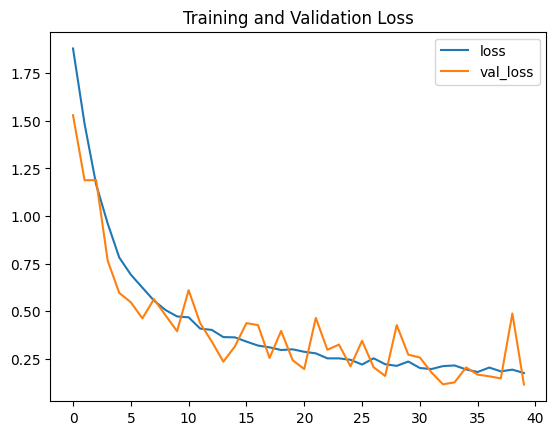

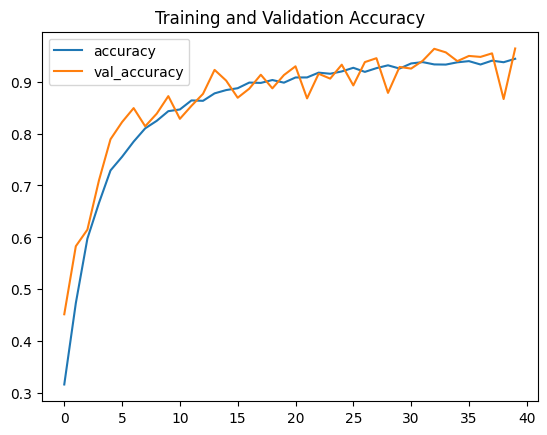

In [18]:
# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Training and Validation Loss')

history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.title('Training and Validation Accuracy')

## Testing the model on test set

In [19]:
def evaluate_model(model, test_ds):
    eval_dict = model.evaluate(test_ds, return_dict=True)
    
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    
    return display_df

In [20]:
results = evaluate_model(model, test_ds)

results.head()

50/50 [==============================] - 6s 25ms/step - loss: 0.1086 - accuracy: 0.9631


loss  accuracy
0  0.108559  0.963125

## Run Prediction on sample images

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


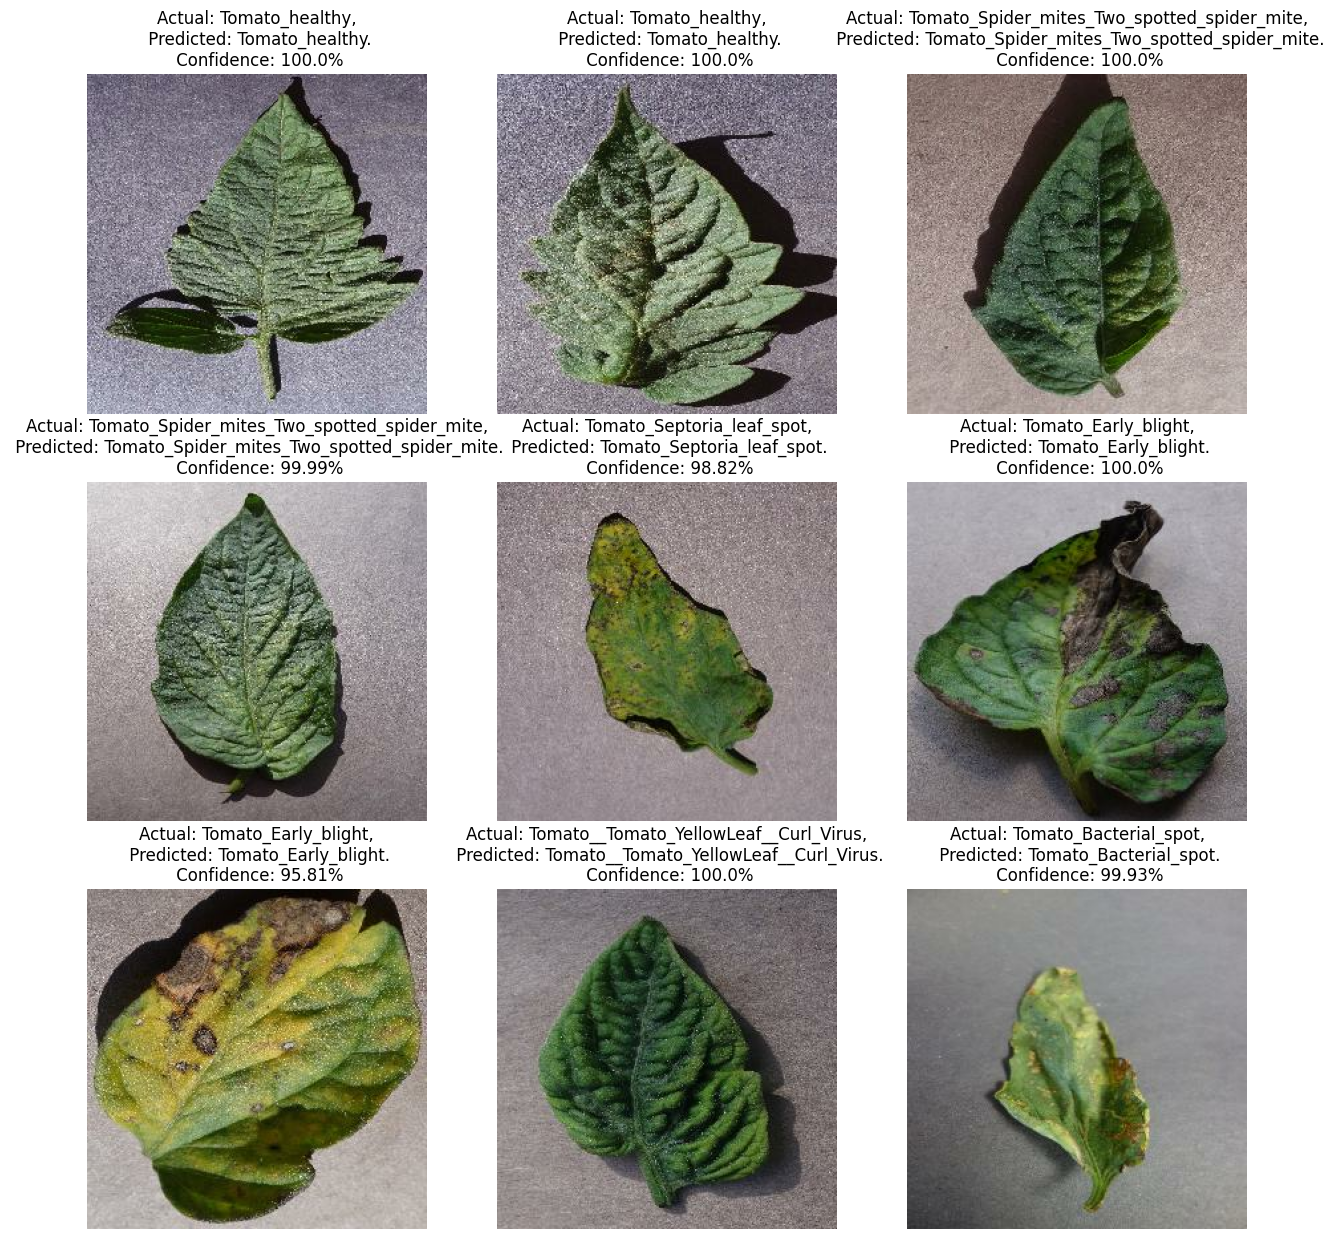

In [22]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [23]:
model_version = max([int(i) for i in os.listdir("models") + [0]]) + 1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets
